## 2. Experiment: Collaborative filtering Recommender with Spark
Done by Kourosh Tajahmadi (kt77) and Marek Schuster (ms2228) 

## Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, count, desc
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
import matplotlib.pyplot as plt

# Start Spark Session
spark = SparkSession.builder \
    .appName('ALS Collaborative Filtering') \
    .getOrCreate()

# Define the schema for papers
papers_schema = StructType([
    StructField("paper_id", IntegerType()),
    StructField("type", StringType()),
    StructField("journal", StringType()),
    StructField("book_title", StringType()),
    StructField("series", StringType()),
    StructField("publisher", StringType()),
    StructField("pages", StringType()),
    StructField("volume", StringType()),
    StructField("number", StringType()),
    StructField("year", StringType()),
    StructField("month", StringType()),
    StructField("postedat", StringType()),
    StructField("address", StringType()),
    StructField("title", StringType()),
    StructField("abstract", StringType())
])

# Load Data
authors_df = spark.read.csv('authors.csv', header=True)
papers_df = spark.read.csv('papers.csv', schema=papers_schema)
keywords_df = spark.read.csv('keywords.csv', header=True)
users_libraries_df = spark.read.text('users_libraries.txt')

# Split users_libraries into two columns (user_hash_id and user_library)
users_libraries_df = users_libraries_df.select(split(users_libraries_df.value, ";").alias("split_values"))
users_libraries_df = users_libraries_df.select(users_libraries_df.split_values[0].alias("user_hash_id"), users_libraries_df.split_values[1].alias("user_library"))



## Exercise 2.1
### Advanced analysis

Sparsity: 99.98305694442851%
+--------------------+-----------+
|        user_hash_id|num_ratings|
+--------------------+-----------+
|f7d5debb9c7d4d9ab...|       1922|
|99eeb9aace7158603...|       1878|
|443153f162584d7d3...|       1877|
|7591cbc78d1c3d0a2...|       1866|
|fd34332d8f9394db7...|       1862|
|ea9769ac9621505f0...|       1763|
|e27640e71b52bf04d...|       1656|
|9be9e397678941ff5...|       1655|
|b487310632926f759...|       1541|
|b419aab6041946949...|       1391|
|474f9b0354a1f536e...|       1361|
|075fa3f0b13d899e5...|       1359|
|d5b818086747040b3...|       1313|
|adf709f390245d9b4...|       1298|
|2906981ae102f6cd3...|       1294|
|1507e0abf427bfc9b...|       1284|
|78023d4e3828c1e06...|       1275|
|622f7b188f30191b4...|       1260|
|9b0d292611c77ee7d...|       1237|
|d67644ecf45f03d95...|       1237|
+--------------------+-----------+
only showing top 20 rows



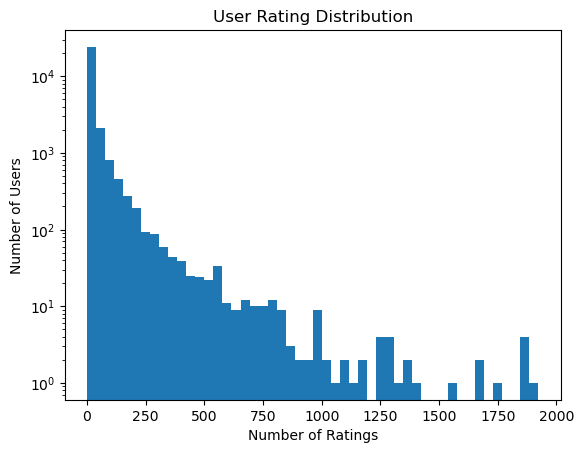

+-------+-----------+
|ratings|num_ratings|
+-------+-----------+
|  80546|        924|
|5842862|        568|
|1242600|        417|
| 305755|        360|
|3467077|        331|
| 309395|        266|
| 740681|        218|
|     99|        209|
|6603134|        209|
| 816066|        169|
| 873540|        153|
| 105595|        151|
| 361498|        149|
|3614773|        148|
| 212874|        147|
|   3283|        141|
|1387765|        138|
| 115158|        138|
|  99857|        136|
|6434100|        133|
+-------+-----------+
only showing top 20 rows



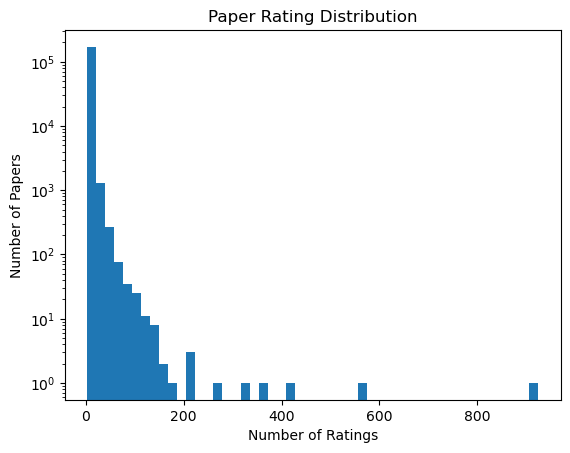

In [2]:
# Task 2.1a) Calculate sparsity
# Considering the user library as ratings given by the user to the paper
numerator = users_libraries_df.select(explode(split(users_libraries_df.user_library, ","))).count()
denominator = users_libraries_df.select(count('user_hash_id')).collect()[0][0] * papers_df.select(count('paper_id')).collect()[0][0]
sparsity = (1.0 - (numerator * 1.0) / denominator) * 100
print(f'Sparsity: {sparsity}%')

# Task 2.1b) Number of ratings given by the users
user_ratings = users_libraries_df.select('user_hash_id', explode(split(users_libraries_df.user_library, ",")).alias('ratings')).groupBy('user_hash_id').agg(count('ratings').alias('num_ratings')).sort(desc('num_ratings'))
user_ratings.show()

# To plot the (number of users, number of ratings) rank-frequency distribution, collect the data to the driver and use matplotlib
num_ratings = [row['num_ratings'] for row in user_ratings.collect()]
plt.hist(num_ratings, bins=50, log=True)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.title('User Rating Distribution')
plt.show()

# Task 2.1c) Number of ratings for each paper
paper_ratings = users_libraries_df.select('user_hash_id', explode(split(users_libraries_df.user_library, ",")).alias('ratings')).groupBy('ratings').agg(count('user_hash_id').alias('num_ratings')).sort(desc('num_ratings'))
paper_ratings.show()

# To plot the (number of items, number of ratings) rank-frequency distribution, collect the data to the driver and use matplotlib
num_ratings = [row['num_ratings'] for row in paper_ratings.collect()]
plt.hist(num_ratings, bins=50, log=True)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Papers')
plt.title('Paper Rating Distribution')
plt.show()


The majority of users only rate a few papers, and a small number of users rate many papers, the user rating distribution follows a power-law distribution. Similarly, a large number of papers only get a few ratings, while a small number of papers get many ratings, the paper rating distribution also follows a power-law distribution. As shown in the plots above with the long tail on the right side of the distribution.

## Exercise 2.2
### Rating matrix preparation

In [3]:
from pyspark.sql import Window
from pyspark.sql.functions import row_number
from pyspark.sql import Row
from pyspark.sql.functions import monotonically_increasing_id, lit, col
from pyspark.sql.functions import array, lit
import random
from pyspark.sql.functions import rand

# Create DataFrame of distinct user_hash_id's and add new column 'user_id'
user_id_df = users_libraries_df.select('user_hash_id').distinct().withColumn('user_id', monotonically_increasing_id())

# Join 'user_id_df' with 'users_libraries_df' to replace 'user_hash_id' with 'user_id' and then drop 'user_hash_id'
users_libraries_df = users_libraries_df.join(user_id_df, 'user_hash_id').drop('user_hash_id')

# Generate positive ratings
positive_ratings = users_libraries_df.select('user_id', explode(split(users_libraries_df.user_library, ",")).alias('paper_id'))
positive_ratings = positive_ratings.withColumn('rating', lit(1))




# Step 1: Count the number of positive ratings for each user
user_positive_ratings_count = positive_ratings.groupBy('user_id').count()

# Get an array of paper_id's from papers_df
paper_ids = papers_df.select('paper_id').rdd.flatMap(lambda x: x).collect()

# Broadcast the paper_ids
paper_ids_broadcast = spark.sparkContext.broadcast(paper_ids)

# For each user_id, take a sample of size 2*count from paper_ids_broadcast
# samploing 2x the number of positive ratings for each user for the worst case, so even if all the positive ratings are sampled, there will still be some negative ratings
unknown_ratings_rdd = user_positive_ratings_count.rdd.flatMap(
    lambda row: [(row.user_id, paper_id) for paper_id in random.sample(paper_ids_broadcast.value, 2 * row['count'])]
)

# Convert unknown_ratings_rdd back to DataFrame
unknown_ratings = unknown_ratings_rdd.toDF(["user_id", "paper_id"])

# Remove instances of user_id,paper_id pair that are in positive_ratings
unknown_ratings = unknown_ratings.subtract(positive_ratings.select('user_id', 'paper_id'))

# For each user, keep the same number of entries as in positive_ratings
window = Window.partitionBy('user_id').orderBy(rand())
unknown_ratings = unknown_ratings.withColumn("row_number", row_number().over(window))
unknown_ratings = unknown_ratings.join(user_positive_ratings_count, ["user_id"], 'left')
unknown_ratings = unknown_ratings.filter(unknown_ratings.row_number <= unknown_ratings['count']).drop('count', 'row_number')

# Assign rating 0 to the selected unrated papers
unknown_ratings = unknown_ratings.withColumn('rating', lit(0))

# Merge positive and unknown ratings dataframes
ratings = positive_ratings.union(unknown_ratings)

# make paper id integers
ratings = ratings.withColumn("paper_id", ratings["paper_id"].cast(IntegerType()))
# make user id integers
ratings = ratings.withColumn("user_id", ratings["user_id"].cast(IntegerType()))

ratings.show()

+-------+--------+------+
|user_id|paper_id|rating|
+-------+--------+------+
|   5312| 3929762|     1|
|   5312|  503574|     1|
|   5312| 5819422|     1|
|   5312| 4238883|     1|
|   5312| 5788061|     1|
|   5312|  462949|     1|
|   5312|  635215|     1|
|   5312|  635216|     1|
|   5312| 4810441|     1|
|   5312| 3481823|     1|
|   5312| 4165233|     1|
|   5312| 3366480|     1|
|   5312| 5984302|     1|
|   5312| 4238942|     1|
|   5312| 5490453|     1|
|   5312| 4636156|     1|
|   5312| 5996865|     1|
|   5312| 4194836|     1|
|   5312| 5828780|     1|
|   5312| 4450195|     1|
+-------+--------+------+
only showing top 20 rows



#### Checks for exercise 2.2, to verify that the data is correct

In [5]:
# check if there are any duplicates in the ratings dataframe by user_id and paper_id (should be none)
ratings.groupBy('user_id', 'paper_id').count().filter('count > 1').show()

+-------+--------+-----+
|user_id|paper_id|count|
+-------+--------+-----+
+-------+--------+-----+



In [6]:
# print the length of the ratings dataframe and positive_ratings dataframe (should be half)
print(ratings.count())
print(positive_ratings.count())

1656962
828481


In [7]:
# print the number of distinct users and papers (should be the same as in the previous exercise)
print(ratings.select('user_id').distinct().count())
print(ratings.select('paper_id').distinct().count())


28416
172079


In [8]:
# print number of ratings 0 and 1 (should be equal)
ratings.groupBy('rating').count().show()

+------+------+
|rating| count|
+------+------+
|     1|828481|
|     0|828481|
+------+------+



In [9]:
# get type of each column (should be integer for ALS algorithm)
ratings.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- paper_id: integer (nullable = true)
 |-- rating: integer (nullable = false)



## Exercise 2.3
### ALS algorithm

In [10]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col

# Define ALS (Alternating Least Squares) model
als = ALS(userCol="user_id", itemCol="paper_id", ratingCol="rating", rank=10, maxIter=10, regParam=0.1,
          nonnegative=True, coldStartStrategy="drop", implicitPrefs=False)

# Fit the model to the data
als_model = als.fit(ratings)

# Generate top 10 paper recommendations for each user
user_recommendations = als_model.recommendForAllUsers(10)

# Display the recommendations
user_recommendations.show()

# # Get the user id for the user with hash id = '1eac022a97d683eace8815545ce3153f'
# user_id = user_hash_ids_dict['1eac022a97d683eace8815545ce3153f']

# Filter the DataFrame based on the user_hash_id
filtered_df = user_id_df.filter(col("user_hash_id") == "1eac022a97d683eace8815545ce3153f")

# Extract the user_id value from the filtered DataFrame
user_id = filtered_df.select("user_id").first()[0]

# Generate top 10 paper recommendations for the specific user
user_specific_recommendations = als_model.recommendForUserSubset(ratings.filter(col('user_id') == user_id), 10)

# Display the recommendations for the specific user
user_specific_recommendations.show()


+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|     12|[{1065504, 1.0001...|
|     26|[{1900128, 0.9634...|
|     27|[{1323394, 0.9780...|
|     28|[{1007784, 0.9962...|
|     31|[{365119, 0.87464...|
|     34|[{2427991, 0.9159...|
|     44|[{246668, 0.97251...|
|     53|[{557226, 0.96676...|
|     65|[{2427991, 0.9409...|
|     76|[{5367917, 0.8176...|
|     78|[{2988913, 0.9681...|
|     81|[{4803572, 0.9927...|
|     85|[{363166, 0.89802...|
|    101|[{1323394, 0.9685...|
|    103|[{1689645, 0.9330...|
|    108|[{8839432, 1.0601...|
|    115|[{2427991, 0.8906...|
|    126|[{12462405, 1.017...|
|    133|[{4255664, 0.8885...|
|    137|[{3106679, 1.0023...|
+-------+--------------------+
only showing top 20 rows

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|   9066|[{6509824, 0.9403...|
+-------+--------------------+



In [11]:
# paper_id's for the user with hash_id = '1eac022a97d683eace8815545ce3153f' not truncated
user_specific_recommendations.select('recommendations.paper_id').show(truncate=False)

+-------------------------------------------------------------------------------------+
|paper_id                                                                             |
+-------------------------------------------------------------------------------------+
|[6509824, 234810, 4502433, 1342587, 956633, 498707, 487344, 255030, 6634601, 2692631]|
+-------------------------------------------------------------------------------------+



## Exercise 2.4
### Recommender System Model Evaluation

In [6]:
from pyspark.ml.evaluation import RegressionEvaluator

# Split the data into training and test sets (70% held out for training, 30% for testing)
(training, test) = ratings.randomSplit([0.7, 0.3])

# Create ALS model
als = ALS(userCol="user_id", itemCol="paper_id", ratingCol="rating", rank=10, maxIter=10, regParam=0.1,
          nonnegative=True, coldStartStrategy="drop", implicitPrefs=False)

# Fit the model to the training data
als_model = als.fit(training)

# Generate predictions on the test data
predictions = als_model.transform(test)

# Create an evaluator object to compute root mean square error
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

# Compute RMSE
rmse = evaluator.evaluate(predictions)

print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.4045844296036243


## Exercise 2.5
### Hyperparameter tuning
#### a)

In [7]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Create ALS model
als = ALS(userCol="user_id", itemCol="paper_id", ratingCol="rating",
          nonnegative=True, coldStartStrategy="drop", implicitPrefs=False, maxIter=10)

# Create an evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Build a parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 25, 50]) \
    .build()

# Cross Validator
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit on the training data
cvModel = crossval.fit(training)

# Find the best model, extract the rank
best_rank = cvModel.bestModel.rank
print(f"Best Rank: {best_rank}")

# Evaluate the model with the best rank
predictions = cvModel.transform(test)
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error for best rank: {rmse}")


Best Rank: 50
Root-mean-square error for best rank: 0.3678530971954015


Task 2.5b)
Observation:

We initially inscreased maxIter in intervals of 5 and later by 10, everytime the rmse got slightly smaller but also the runtime increased, since there was no significant improvement it seems not worth it to increase it above maybe 20. On maxIter=50 the programm crashed, so we took 45 as the last step instead.

| maxIter | RMSE | RunTime |
|---------|------|---------|
| 10      |0.3681465947407143      |85.3         |
| 15      |0.3558248210197017      |118.5         |
| 20      |0.35225421281619396      |151.4         |
| 25      |0.35120510789456383      |182.2         |
| 30      |0.3490047432019176      |224.5         |
| 40      |0.3480143197292499      |287.4         |
| 45      |0.3482301655714043      |294.4         |

By increasing maxIter, the model may converge to a better solution. However, this might also increase the risk of overfitting, especially if the number of iterations is too high. Moreover, a higher maxIter increases the computation time and at some point is not worth it. In our case maxIter 15 seems like a good trade-off between RMSE and runtime.

#### b)

In [16]:
import time
start_time = time.time()
# Create ALS model
als = ALS(userCol="user_id", itemCol="paper_id", ratingCol="rating", rank=best_rank,
          nonnegative=True, coldStartStrategy="drop", implicitPrefs=False, maxIter=45)

# Fit the model to the training data
als_model = als.fit(training)

# Generate predictions on the test data
predictions = als_model.transform(test)

# Compute RMSE
rmse = evaluator.evaluate(predictions)

print(f"Root-mean-square error with increased maxIter = {rmse}")
run_time = (time.time() - start_time)
print("%.1f" % (run_time))

Root-mean-square error with increased maxIter = 0.3482301655714043
294.4
